In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import embedders
import hyperdt
import torch

import numpy as np
import matplotlib.pyplot as plt

INFO: Using numpy backend


In [13]:
def test_sig(sig, seed=42, num_points=1000, num_classes=2, fix_x_dim=None):
    pm = embedders.manifolds.ProductManifold(signature=sig)

    X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, num_points=num_points, num_classes=num_classes, seed=seed)

    sig_r = [(x, y) for (y, x) in sig]
    if fix_x_dim is not None:
        X_fixed = torch.concat([X[:, :fix_x_dim], torch.ones(len(X), 1), X[:, fix_x_dim:]], dim=1)
    else:
        X_fixed = X
    dt_q = hyperdt.torch.product_space_DT.ProductSpaceDT(signature=sig_r)
    dt_q.fit(X_fixed, y)
    print(f"Quentin DT: {dt_q.score(X_fixed, y).float().mean().item():.4f}")

    dt_old = embedders.tree.TorchProductSpaceDT(signature=sig)
    dt_old.fit(X, y)
    print(f"Old DT: {dt_old.score(X, y).float().mean().item():.4f}")

    dt_new = embedders.tree_new.ProductSpaceDT(pm=pm)
    dt_new.fit(X, y)
    print(f"New DT: {dt_new.score(X, y).float().mean().item():.4f}")

    return dt_q, dt_old, dt_new, X, y

_ = test_sig([(-1, 4)])

/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


Quentin DT: 0.9950
Old DT: 0.9950
New DT: 0.9950


In [56]:
# Try a few more signatures
print("Hyp")
dt_q, dt_old, dt_new, X, y = test_sig([(-1, 4)], seed=1)
print()

print("Euc")
dt_q, dt_old, dt_new, X, y = test_sig([(0, 4)], seed=2, fix_x_dim=0)
print()

print("Sph")
dt_q, dt_old, dt_new, X, y = test_sig([(1, 4)], seed=3)
print()

print("Multi-Hyp")
dt_q, dt_old, dt_new, X, y = test_sig([(-1, 2), (-1, 2)], seed=4)
print()

print("Multi-Sph")
dt_q, dt_old, dt_new, X, y = test_sig([(1, 2), (1, 2)], seed=5)
print()

print("H x E")
dt_q, dt_old, dt_new, X, y = test_sig([(-1, 2), (0, 2)], seed=6, fix_x_dim=3)
print()

print("S x E")
dt_q, dt_old, dt_new, X, y = test_sig([(1, 2), (0, 2)], seed=6, fix_x_dim=2)
print()

print("H x S")
dt_q, dt_old, dt_new, X, y = test_sig([(-1, 2), (1, 2)], seed=6)
print()

print("H x S x E")
dt_q, dt_old, dt_new, X, y = test_sig([(-1, 2), (0, 2), (1, 2)], seed=7, fix_x_dim=6)
print()

Hyp


/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


Quentin DT: 0.9450
Old DT: 0.9450
New DT: 0.9450

Euc
Quentin DT: 0.9010
Old DT: 0.9010
New DT: 0.9010

Sph
Quentin DT: 0.9220
Old DT: 0.9160
New DT: 0.9220

Multi-Hyp
Quentin DT: 0.9990
Old DT: 0.9990
New DT: 0.9990

Multi-Sph
Quentin DT: 0.9440
Old DT: 0.9110
New DT: 0.9400

H x E
Quentin DT: 0.9920
Old DT: 0.9920
New DT: 0.9920

S x E
Quentin DT: 0.8750
Old DT: 0.8710
New DT: 0.8890

H x S
Quentin DT: 0.9880
Old DT: 0.9880
New DT: 0.9880

H x S x E
Quentin DT: 0.9800
Old DT: 0.9590
New DT: 0.9590



In [55]:
# Sanity check on angular midpoints

_v1 = torch.randn(1)
_v2 = torch.randn(1)

_m = embedders.midpoint.euclidean_midpoint(
    torch.atan2(torch.tensor(1), _v1),
    torch.atan2(torch.tensor(1), _v2)
)

print(1 / torch.tan(torch.atan2(torch.tensor(1), _v1)), _v1)

print(
    1 / torch.tan(_m),
    (_v1 + _v2) / 2
)

tensor([-0.3311]) tensor([-0.3311])
tensor([0.4833]) tensor([0.4833])


In [39]:
torch.tan(torch.atan2(torch.tensor(torch.pi), torch.tensor(1)))

tensor(3.1416)

In [ ]:
theta = dt_new.tree.theta
feature = dt_new.tree.feature
angles, _, _, _ = dt_new.preprocess(X)
embedders.tree_new.angular_greater(torch.tensor(theta).reshape(1,1), angles[1, 3].reshape(1,1)).item()

False

In [ ]:
embedders.tree_new.angular_greater(torch.tensor(theta).flatten(), angles[1, 3].flatten()).item()

False

In [ ]:
def agg_nodes(tree, nodes):
    if tree is not None:
        nodes.append(tree)
        agg_nodes(tree.left, nodes)
        agg_nodes(tree.right, nodes)
    return nodes

dt_old_nodes = agg_nodes(dt_old.tree, [])
[(x.feature.item(), f"{x.theta.item():.4f}") for x in dt_old_nodes if x.feature is not None]

[(2, '1.9900'),
 (0, '1.3944'),
 (1, '1.0036'),
 (1, '1.4063'),
 (0, '1.8603'),
 (2, '1.4846'),
 (0, '1.5846')]

In [ ]:
dt_q_nodes = agg_nodes(dt_q.tree, [])
[(x.feature-1, f"{x.theta.item():.4f}") for x in dt_q_nodes if x.feature is not None]
# Subtract 1 because Quentin indexes ambient dimensions
# This only works for single-manifold items

[(2, '1.9918'),
 (0, '1.3991'),
 (1, '1.0075'),
 (1, '1.4655'),
 (0, '1.8656'),
 (2, '1.4885'),
 (0, '1.5847')]

In [ ]:
[(x.feature, f"{x.theta:.4f}") for x in dt_new.nodes]

[(2, '1.9918'),
 (0, '1.3991'),
 (1, '1.0075'),
 (1, '1.4655'),
 (0, '1.8656'),
 (2, '1.4885'),
 (0, '1.5847')]

In [ ]:
_x = torch.linspace(-2*torch.pi, 2*torch.pi, 100)

embedders.tree_new.angular_greater(_x, _x)

tensor([[ True,  True,  True,  ..., False, False,  True],
        [False,  True,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ..., False, False,  True]])

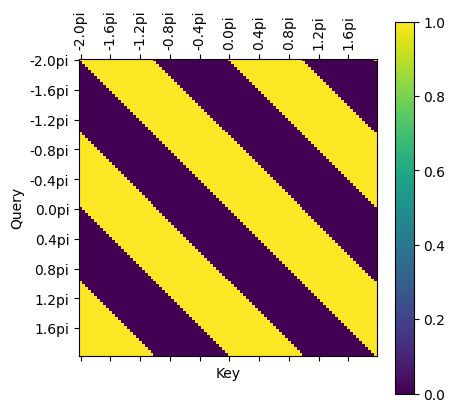

In [ ]:
plt.matshow(
    embedders.tree_new.angular_greater(_x, _x).detach().numpy().astype(int)
)
plt.xticks(range(len(_x))[::10], [f"{x.item() / torch.pi:.1f}pi" for x in _x[::10]], rotation=90)
plt.yticks(range(len(_x))[::10], [f"{x.item() / torch.pi:.1f}pi" for x in _x[::10]])
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()
plt.show()

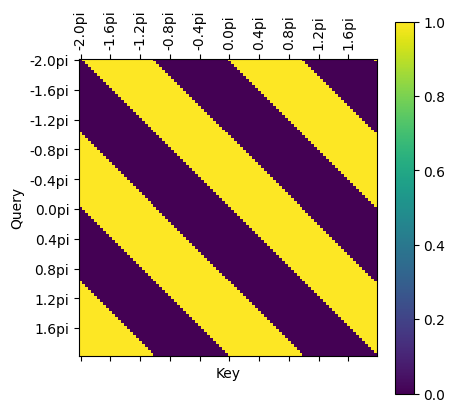

In [ ]:
plt.matshow(
    np.array([embedders.tree.circular_greater(_x, x).detach().numpy().astype(int) for x in _x])
)
plt.xticks(range(len(_x))[::10], [f"{x.item() / torch.pi:.1f}pi" for x in _x[::10]], rotation=90)
plt.yticks(range(len(_x))[::10], [f"{x.item() / torch.pi:.1f}pi" for x in _x[::10]])
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()
plt.show()

In [ ]:
embedders.tree_new.angular_greater(_x, _x[:50]).shape

torch.Size([100, 50])

In [ ]:
_xx =  torch.randn(100, 5)

(_xx.sum(dim=0) / _xx.sum()).argmax()

tensor(1)

In [ ]:
0 - .75*torch.pi % torch.pi

-2.356194490192345

In [ ]:
_v1 = torch.randn(1)
_v2 = torch.randn(10)
_v2[0] = _v1 + torch.pi + .01 % (2 * torch.pi)
print(_v1)
print(
    [(x.item(), y.item()) for x,y in zip(_v2, embedders.tree_new.angular_greater(_v1, _v2).flatten())]
)

tensor([-1.1885])
[(1.9631205797195435, False), (-0.8099784255027771, True), (-0.09882992506027222, True), (-0.07330941408872604, True), (-2.0440964698791504, False), (1.2330280542373657, True), (0.22466133534908295, True), (0.14706215262413025, True), (0.10357317328453064, True), (-0.4002175033092499, True)]


In [88]:
# Does RF work?


pm = embedders.manifolds.ProductManifold(signature=[(-1,3), (0,3), (1,3)])
prf = embedders.tree_new.ProductSpaceRF(pm=pm, n_estimators=100)

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm)
prf.fit(X, y)

/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


ProductSpaceRF(pm=<embedders.manifolds.ProductManifold object at 0x3662e6ef0>)

In [89]:
prf.score(X, y).float().mean().item()

0.9879999756813049

In [94]:
for tree in prf.trees:
    print(f"{tree.score(X, y).float().mean().item():.3f}", tree.permutations.tolist())

0.885 [6, 4, 1]
0.870 [8, 4, 0]
0.974 [4, 8, 7]
0.896 [7, 5, 1]
0.881 [6, 0, 3]
0.898 [3, 2, 6]
0.882 [0, 4, 3]
0.850 [7, 1, 6]
0.872 [8, 2, 5]
0.868 [0, 8, 4]
0.939 [0, 1, 5]
0.976 [6, 3, 4]
0.822 [8, 3, 7]
0.920 [1, 3, 0]
0.929 [4, 2, 6]
0.872 [8, 1, 2]
0.849 [4, 5, 8]
0.896 [0, 4, 2]
0.967 [8, 7, 3]
0.916 [1, 0, 4]
0.929 [0, 2, 5]
0.893 [7, 0, 2]
0.914 [2, 7, 8]
0.908 [4, 1, 8]
0.883 [3, 6, 5]
0.865 [0, 6, 8]
0.904 [2, 1, 7]
0.893 [2, 8, 0]
0.872 [5, 2, 4]
0.817 [8, 4, 2]
0.854 [5, 8, 1]
0.872 [0, 8, 6]
0.861 [7, 0, 4]
0.951 [5, 6, 1]
0.964 [6, 8, 5]
0.866 [0, 8, 7]
0.986 [7, 8, 6]
0.827 [6, 8, 2]
0.926 [0, 1, 2]
0.894 [0, 8, 7]
0.864 [7, 6, 0]
0.921 [0, 1, 3]
0.888 [0, 2, 7]
0.940 [0, 5, 1]
0.884 [5, 8, 2]
0.853 [6, 5, 3]
0.854 [1, 8, 5]
0.876 [5, 3, 1]
0.847 [1, 3, 5]
0.947 [5, 1, 0]
0.904 [5, 7, 0]
0.888 [0, 6, 2]
0.953 [6, 8, 5]
0.862 [4, 2, 1]
0.860 [0, 6, 8]
0.856 [8, 6, 1]
0.821 [1, 7, 2]
0.921 [0, 5, 8]
0.910 [8, 1, 7]
0.903 [8, 6, 3]
0.870 [1, 2, 4]
0.726 [3, 6, 2]
0.860 [3